## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

In [1]:
# your code here 
import seaborn as sns
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt

np.random.seed(123)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [95]:
imd = gpd.read_file('data/IMD/lab04_imd.shp')

imd.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
0,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,29199,9,City of London 001A,E09000001,City of London,...,5,1.503,1615,1,1296,175,656,465,715.00,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,226191.272990,2433.960112,30379,10,City of London 001B,E09000001,City of London,...,7,1.196,2969,1,1156,182,580,394,619.75,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,57302.966538,1142.359799,14915,5,City of London 001C,E09000001,City of London,...,6,2.207,162,1,1350,146,759,445,804.00,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,190738.760504,2167.868343,8678,3,City of London 001E,E09000001,City of London,...,8,1.769,849,1,1121,229,692,200,683.00,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,144195.846857,1935.510354,14486,5,Barking and Dagenham 016A,E09000002,Barking and Dagenham,...,5,0.969,4368,2,2040,522,1297,221,1284.50,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [96]:
imd = imd.loc[df['LADnm']=='Liverpool', :]
imd.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
6348,E01006512,Liverpool 031A,Liverpool 031A,283906.863775,3063.168774,14664,5,Liverpool 031A,E08000012,Liverpool,...,1,0.536,8031,3,2975,255,2639,81,2649.50,"POLYGON ((335888.000 390042.000, 336203.000 39..."
6349,E01006513,Liverpool 060A,Liverpool 060A,555037.185423,5835.725743,11173,4,Liverpool 060A,E08000012,Liverpool,...,1,0.974,4329,2,4418,103,4222,93,4257.75,"POLYGON ((335374.808 390547.998, 335405.406 39..."
6350,E01006514,Liverpool 037A,Liverpool 037A,262030.747956,3243.503128,3299,2,Liverpool 037A,E08000012,Liverpool,...,1,0.550,7888,3,1760,87,1439,234,1538.25,"POLYGON ((335650.536 389928.121, 335677.916 38..."
6351,E01006515,Liverpool 037B,Liverpool 037B,366499.754871,4273.694263,1875,1,Liverpool 037B,E08000012,Liverpool,...,3,0.615,7285,3,1438,176,1013,249,1014.75,"POLYGON ((335178.000 389642.000, 335222.397 38..."
6352,E01006518,Liverpool 044A,Liverpool 044A,235181.260598,2743.746370,330,1,Liverpool 044A,E08000012,Liverpool,...,2,0.564,7747,3,1732,287,971,474,993.00,"POLYGON ((335528.316 389067.946, 335612.896 38..."


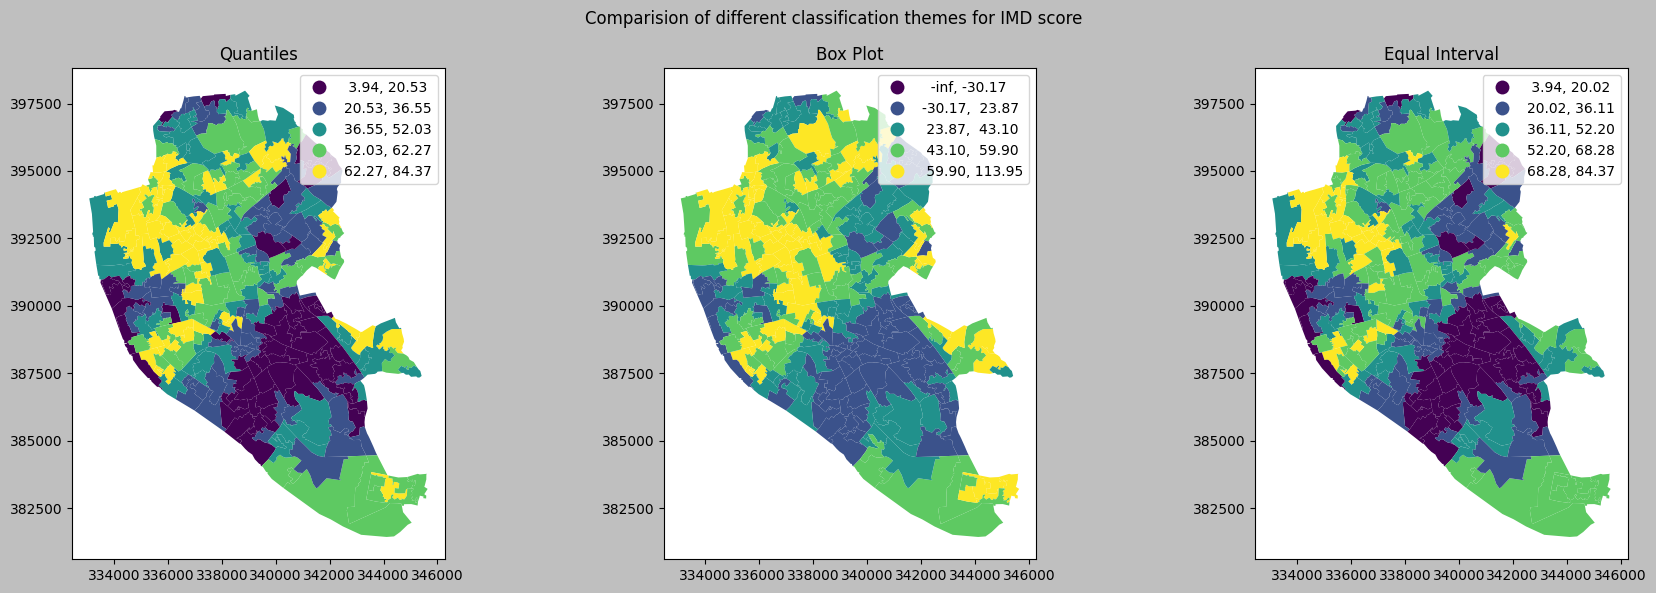

In [99]:
# Set up figure and axis
f, ax = plt.subplots(1,3, figsize=(18, 6))

f.suptitle('Comparision of different classification themes for IMD score')

# Plot % to leave
df1.plot(column='IMDScore', scheme='Quantiles', 
        legend=True, ax=ax[0])
ax[0].set_title('Quantiles')

df1.plot(column='IMDScore', scheme='BoxPlot', 
        legend=True, ax=ax[1])
ax[1].set_title('Box Plot')

df1.plot(column='IMDScore', scheme='EqualInterval', 
        legend=True, ax=ax[2])
ax[2].set_title('Equal Interval')

plt.tight_layout()

# Change background color of the figure
f.set_facecolor('0.75')

# Draw
plt.show()

In [100]:
%time w = weights.Queen.from_dataframe(imd, ids='lsoa11cd')

CPU times: user 30 ms, sys: 3.18 ms, total: 33.2 ms
Wall time: 34.6 ms


In [101]:
w['E01006512']

{'E01033768': 1.0,
 'E01006673': 1.0,
 'E01006513': 1.0,
 'E01006751': 1.0,
 'E01033757': 1.0,
 'E01006679': 1.0}

/var/folders/c3/71m7w1k51m356vg23mpnvxn00000gn/T/ipykernel_16025/4000493826.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df1.loc[w.islands, :].plot(color='red', ax=ax);


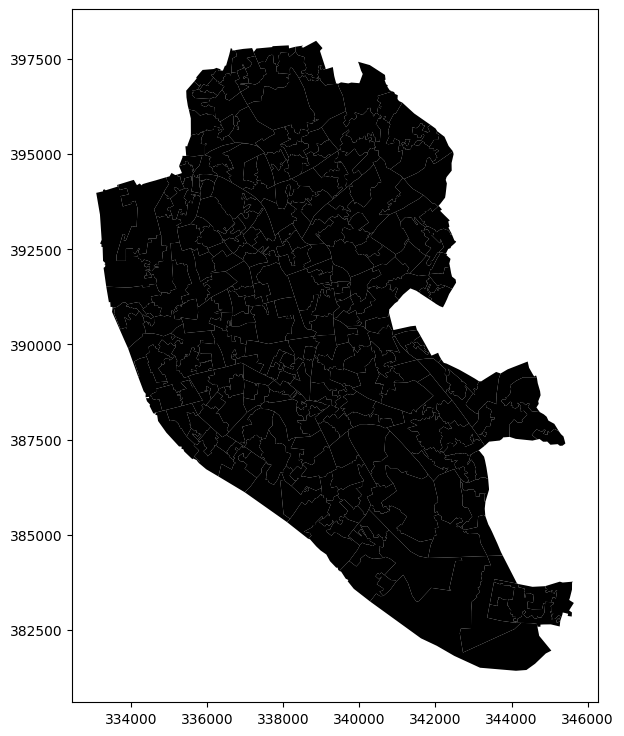

In [102]:
ax = df1.plot(color='k', figsize=(9, 9))
df1.loc[w.islands, :].plot(color='red', ax=ax);

In [103]:
# Row standardize the matrix
w.transform = 'R'

In [104]:
w['E01006512']

{'E01033768': 0.16666666666666666,
 'E01006673': 0.16666666666666666,
 'E01006513': 0.16666666666666666,
 'E01006751': 0.16666666666666666,
 'E01033757': 0.16666666666666666,
 'E01006679': 0.16666666666666666}

In [109]:
imd['w_IMDScore'] = weights.lag_spatial(w, imd['IMDScore'])

In [111]:
imd['pct_IMDScore_std'] = (imd['IMDScore'] - imd['IMDScore'].mean()) / imd['IMDScore'].std()

imd['w_pct_IMDScore_std'] = weights.lag_spatial(w, imd['pct_IMDScore_std'])


imd[['lsoa11cd', 'IMDScore', 'w_IMDScore', 'pct_IMDScore_std', 'w_pct_IMDScore_std']].head()


,lsoa11cd,IMDScore,w_IMDScore,pct_IMDScore_std,w_pct_IMDScore_std
6348,E01006512,19.654,44.516833,-1.109425,0.096993
6349,E01006513,24.323,30.025667,-0.882871,-0.606161
6350,E01006514,43.775,42.787600,0.060997,0.013086
6351,E01006515,51.962,39.345125,0.458254,-0.153953
6352,E01006518,68.396,60.408200,1.255680,0.868089


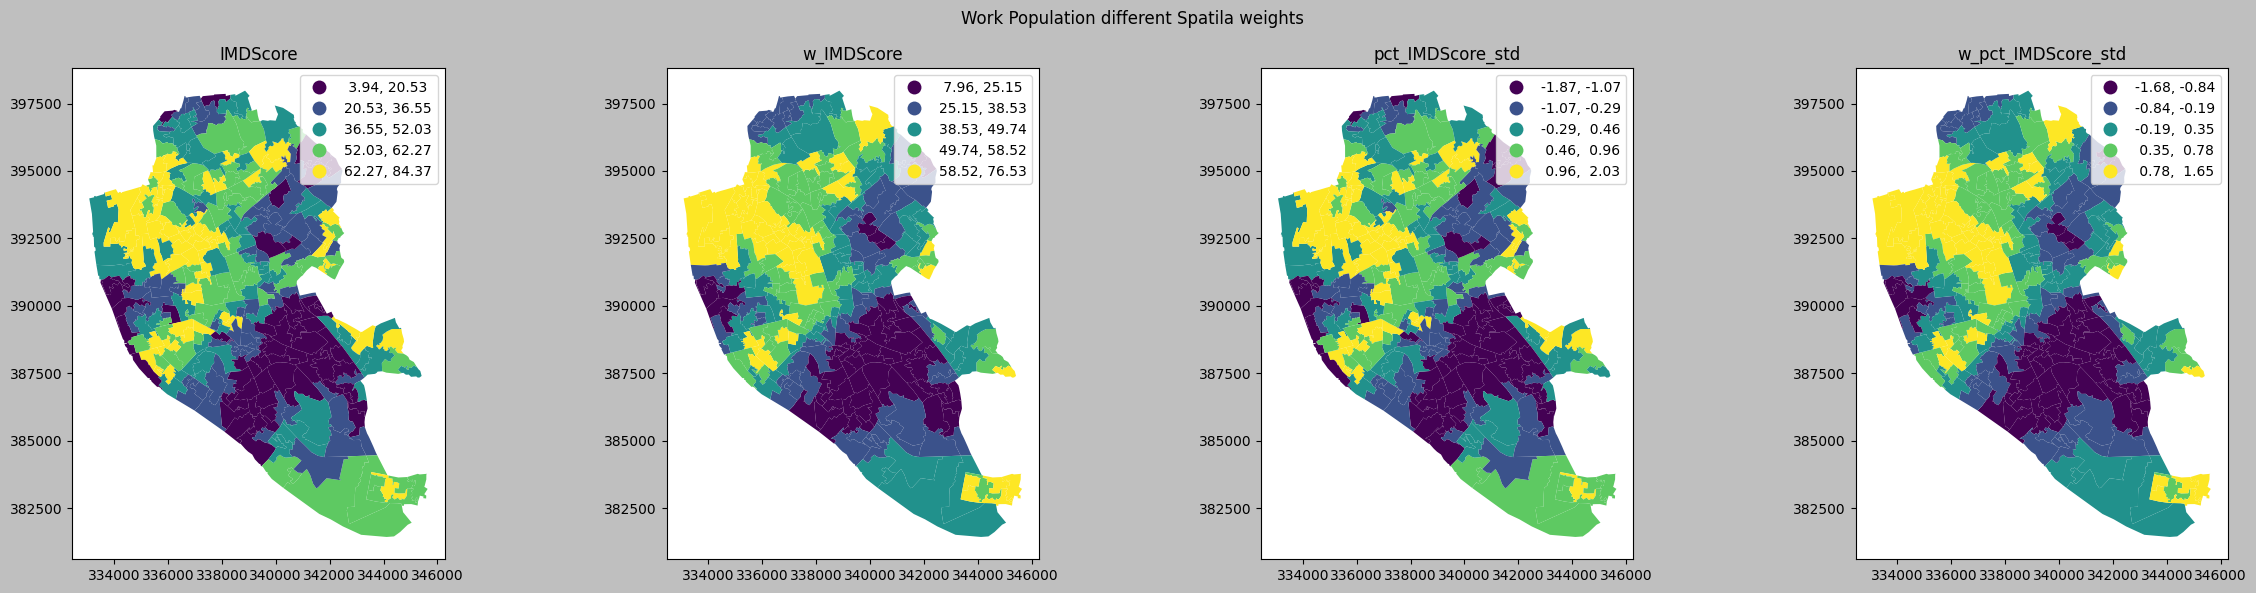

In [113]:
f, ax = plt.subplots(1,4, figsize=(24, 6))

f.suptitle('Work Population different Spatila weights')

# Plot % to leave
imd.plot(column='IMDScore', scheme='Quantiles', 
        legend=True, ax=ax[0])
ax[0].set_title('IMDScore')

imd.plot(column='w_IMDScore', scheme='Quantiles', 
        legend=True, ax=ax[1])
ax[1].set_title('w_IMDScore')

imd.plot(column='pct_IMDScore_std', scheme='Quantiles', 
        legend=True, ax=ax[2])
ax[2].set_title('pct_IMDScore_std')

imd.plot(column='w_pct_IMDScore_std', scheme='Quantiles', 
        legend=True, ax=ax[3])
ax[3].set_title('w_pct_IMDScore_std')

plt.tight_layout()

# Change background color of the figure
f.set_facecolor('0.75')

# Draw
plt.show()


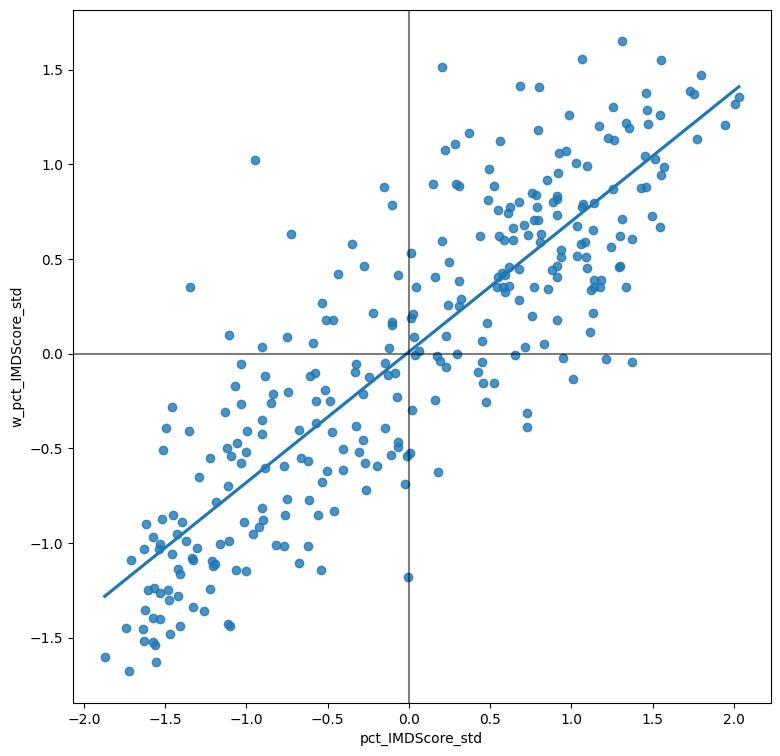

In [114]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='pct_IMDScore_std', y='w_pct_IMDScore_std', data=imd, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [122]:
mi = esda.Moran(imd['pct_IMDScore_std'], w)

#value of the statistic
mi.I

0.6896035100024692

In [123]:
#p-value
mi.p_sim

0.001

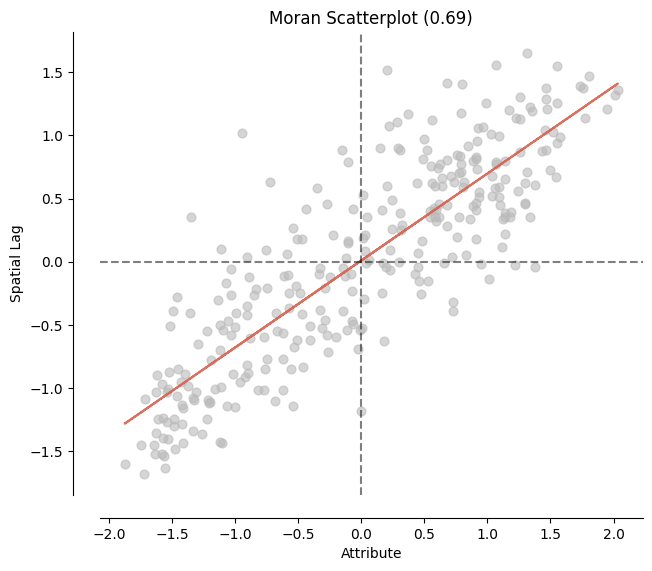

In [124]:
moran_scatterplot(mi);

In [126]:
lisa = esda.Moran_Local(imd['pct_IMDScore_std'], w)

# Break observations into significant or not
imd['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
imd['quadrant'] = lisa.q

imd['significant'].head()

6348    False
6349     True
6350    False
6351    False
6352     True
Name: significant, dtype: bool

In [127]:
lisa.p_sim[:5]

array([0.387, 0.044, 0.5  , 0.35 , 0.021])

In [128]:
df1['quadrant'].head()

6348    1
6349    1
6350    1
6351    2
6352    2
Name: quadrant, dtype: int64

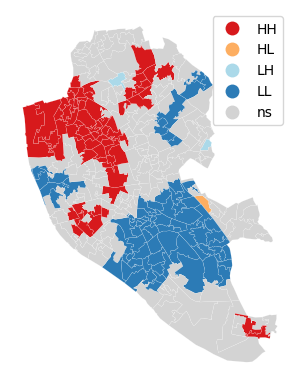

In [130]:
lisa_cluster(lisa, imd);

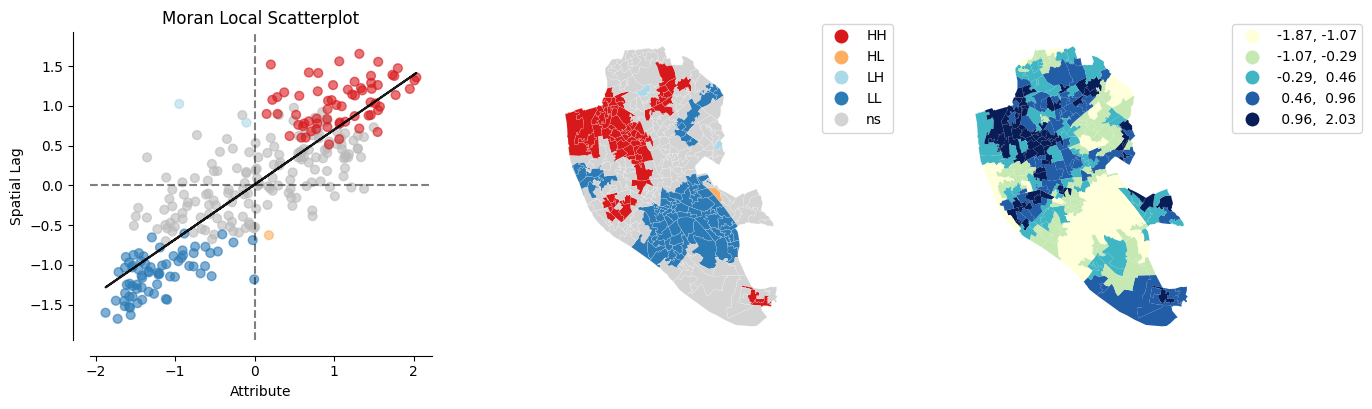

In [131]:
plot_local_autocorrelation(lisa, imd, 'pct_IMDScore_std');

For this part I would like you to experiment with Data from Amstedam. However this will require you to find the dataset yourself!

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

In [148]:
# your code here (Edwin - Question 1)
def create_contiguity_weights(file, index_col):
    
    dataset = gpd.read_file(file)
    w_queen = weights.Queen.from_dataframe(dataset, ids=index_col)
    
    return w_queen

file = 'data/IMD/lab04_imd.shp'
w_1 = create_contiguity_weights(file,'lsoa11cd')
w_1['E01006513']
#w_1.plot(imd)

{'E01006512': 1.0,
 'E01033757': 1.0,
 'E01033760': 1.0,
 'E01033761': 1.0,
 'E01006747': 1.0,
 'E01006515': 1.0,
 'E01033756': 1.0,
 'E01006514': 1.0,
 'E01006751': 1.0}

In [170]:
# your code here (Heqnes - Question 2)
"""Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.
"""

from splot.esda import moran_scatterplot
from esda.moran import Moran


In [176]:
def calculate_morans_i(w,y):
    # Moran’s I hesaplama
    moran = Moran(y, w)
    
    return moran.I, moran.p_sim

w = weights.Queen.from_dataframe(imd)
mo = calculate_morans_i(w, imd['IMDScore'])

print(f"Moran's I: {mo[0]}, P-value: {mo[1]}")

Moran's I: 0.6896035100024693, P-value: 0.001


/var/folders/c3/71m7w1k51m356vg23mpnvxn00000gn/T/ipykernel_16025/1207211302.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(imd)


In [142]:
# your code here (Mannan - Question 3)

def standardize_weights(w, a):
    
    #dw_a = weights.lag_spatial(w, a)
    
    # Row standardize the matrix
    w.transform = 'R'

    Pct_std = (a - a.mean()) / a.std()
    w_Pct_std = weights.lag_spatial(w, Pct_std)
    return w_Pct_std

w = weights.Queen.from_dataframe(imd, ids='lsoa11cd')

#add row with weught standardized IMDScores
imd['w_std_IMDScore'] = standardize_weights(w, imd['IMDScore'])

#view table
imd[['lsoa11cd','IMDScore','w_std_IMDScore']]


,lsoa11cd,IMDScore,w_std_IMDScore
6348,E01006512,19.654,0.096993
6349,E01006513,24.323,-0.606161
6350,E01006514,43.775,0.013086
6351,E01006515,51.962,-0.153953
6352,E01006518,68.396,0.868089
...,...,...,...
32839,E01033764,74.468,0.942644
32840,E01033765,59.599,0.048876
32841,E01033766,21.895,-1.150346
32842,E01033767,66.704,0.349709


In [ ]:

imd = imd.set_index("lsoa11cd")

In [166]:
# your code here (Nils - Question 4)

def create_distance_weights(coordinates, treshold): #define function with variables coordinates for data set and treshold distamce.
    
    w_dist_based = weights.DistanceBand.from_dataframe(coordinates, treshold)  

    return w_dist_based

test_matrix = create_distance_weights(imd, 1000)    #test return matrix
test_matrix['E01006514']                            #check for specific coordinate

{'E01006512': 1.0,
 'E01006513': 1.0,
 'E01006515': 1.0,
 'E01006518': 1.0,
 'E01006673': 1.0,
 'E01033754': 1.0,
 'E01033757': 1.0,
 'E01033761': 1.0,
 'E01033768': 1.0}

In [181]:
# your code here (Renee - Question 5)
#create a spatial weights by using the Queen contiguity method in Pysal
w = weights.Queen.from_dataframe(imd)


/var/folders/c3/71m7w1k51m356vg23mpnvxn00000gn/T/ipykernel_16025/4279591000.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(imd)


In [186]:
from splot.esda import moran_scatterplot

In [205]:
y= imd['IMDScore']

def plot_moran_1 (w, y):
    """
    Creates and displays a Moran plot for the attribute.
    
    Parameters:
    W : libpysal weights object
        The spatial weights matrix created using PySAL.
    y : array-like
        The attribute array for which Moran's I will be calculated.
    """
    # Calculate Moran by putting the weight object and the array against each other 
    moran = Moran(y, w)

   # Moran scatter plot oluşturma
    fig, ax = moran_scatterplot(moran)
    plt.show()

    # Save the plot of the iIMDScore of liverpool as an image file
    fig.savefig('data/moran_plot.png')
    


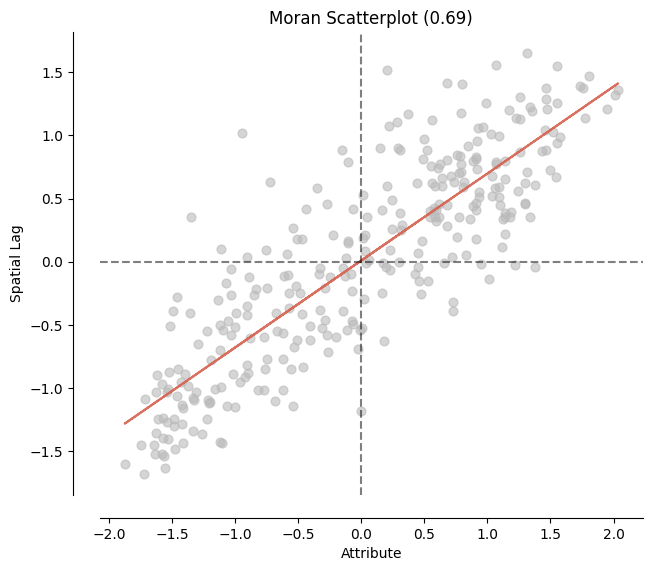

In [206]:
plot_moran_1(w,y)